In [136]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score


## Import, Seperate Data

In [3]:
sing_df = pd.read_excel("sheets/land_use_constrained_data.xlsx", sheet_name=1, header=5, usecols="B:V", nrows=9)

sf_df = pd.read_excel("sheets/land_use_constrained_data.xlsx", sheet_name=1, header=55, usecols="B:V", nrows=11)

sing_df

,Planning zone,# of Zone Types,% Open Space,% Residential,% Commercial,% Industrial,% Mixed Use,% Paved Area,Distance covered in 30 minutes using Public Transportation (km),Distance covered in 30 minutes using a Car (km),...,Distance covered in 30 minutes Cycling (km),"Cost of daily commute per capita, per km using bus (S$)",Cost of daily commute per capita per km using MRT (S$),Cost of daily commute per capita per km Driving (S$),% households with income >= USD8000/month,% residents with high school degrees,% residents with university degrees,% residents employed,% residents 15y + literate,% residents 15y + literate in 2+ languages
0,Bukit Merah,5,0.387,0.283,0.121,0.021,0.063,0.126,6.13,14.66,...,6.84,0.13,0.06,0.30,0.4105,0.6912,0.3211,0.6121,0.9546,0.6615
1,Bukit Timah,5,0.030,0.655,0.004,0.003,0.156,0.152,1.02,15.41,...,4.94,0.13,0.06,0.30,0.6971,0.9217,0.6633,0.5877,0.9912,0.7409
2,Geylang,5,0.063,0.416,0.233,0.023,0.073,0.193,4.16,22.02,...,6.11,0.13,0.06,0.29,0.4081,0.6993,0.3013,0.6311,0.9540,0.6697
3,Kallang,5,0.285,0.288,0.126,0.027,0.063,0.211,5.96,19.98,...,6.17,0.13,0.06,0.30,0.4116,0.6888,0.3311,0.6217,0.9513,0.6481
4,Novena,5,0.118,0.579,0.054,0.022,0.059,0.168,10.74,21.14,...,6.41,0.13,0.06,0.30,0.5478,0.8130,0.4786,0.6261,0.9740,0.7019
5,Queenstown,5,0.115,0.454,0.156,0.045,0.072,0.159,11.36,12.65,...,7.32,0.12,0.06,0.29,0.4482,0.7317,0.3735,0.6015,0.9627,0.6721
6,Tanglin,5,0.191,0.621,0.030,0.016,0.030,0.112,4.63,18.58,...,6.34,0.15,0.08,0.32,0.7249,0.9507,0.7377,0.6097,0.9949,0.7162
7,Toa Payoh,5,0.077,0.457,0.153,0.001,0.109,0.203,5.62,21.01,...,6.71,0.12,0.06,0.29,0.4084,0.7269,0.3196,0.6065,0.9584,0.6700
8,CBD Area,5,0.319,0.130,0.190,0.040,0.126,0.193,6.23,18.32,...,5.23,0.16,0.08,0.32,0.5858,0.8288,0.5620,0.6507,0.9742,0.7050


In [23]:
landuse = sing_df.iloc[:, 2:8]
dists = sing_df.iloc[:, 8:12]
costs = sing_df.iloc[:, 12:15]
qol = sing_df.iloc[:, 15:22]
qol

,% households with income >= USD8000/month,% residents with high school degrees,% residents with university degrees,% residents employed,% residents 15y + literate,% residents 15y + literate in 2+ languages
0,0.4105,0.6912,0.3211,0.6121,0.9546,0.6615
1,0.6971,0.9217,0.6633,0.5877,0.9912,0.7409
2,0.4081,0.6993,0.3013,0.6311,0.9540,0.6697
3,0.4116,0.6888,0.3311,0.6217,0.9513,0.6481
4,0.5478,0.8130,0.4786,0.6261,0.9740,0.7019
5,0.4482,0.7317,0.3735,0.6015,0.9627,0.6721
6,0.7249,0.9507,0.7377,0.6097,0.9949,0.7162
7,0.4084,0.7269,0.3196,0.6065,0.9584,0.6700
8,0.5858,0.8288,0.5620,0.6507,0.9742,0.7050


## Dimensionality Reduction 

### Reduce dimensions

In [81]:
def get_pca_vals(df, name):
    scaled_df  = preprocessing.scale(df)
    pca = PCA()
    pca.fit(scaled_df)

    pca_data = pca.transform(scaled_df)

    #The following code constructs the Scree plot
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    short_labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    labels = [name + '_PC' + str(x) for x in range(1, len(per_var)+1)]
    
    fig, (ax0, ax) = plt.subplots(nrows=1, ncols=2, figsize=[10,3])
    ax0.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=short_labels)
    ax0.set_ylabel('Percentage of Explained Variance')
    ax0.set_xlabel('Principal Component')
    ax0.set_title('Scree Plot')
    # plt.close()


    pca_df = pd.DataFrame(pca_data, columns=labels)

    # plot_fig, ax = plt.subplots()
 
    ax.scatter(pca_df[f"{name}_PC1"], pca_df[f"{name}_PC2"])
    ax.set_title('PCA Graph')
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    
    for sample in pca_df.index:
        ax.annotate(sample, (pca_df[f"{name}_PC1"].loc[sample], pca_df[f"{name}_PC2"].loc[sample]))
    
    plt.close()
    

    return pca_df, fig

In [83]:
df0, f = get_pca_vals(landuse, name="landuse")
landuse_pca = df0.iloc[:, 0:2]
landuse_pca
df0

,landuse_PC1,landuse_PC2,landuse_PC3,landuse_PC4,landuse_PC5,landuse_PC6
0,-0.796598,1.856685,-1.122299,-0.438002,-0.654820,-0.003496
1,2.871224,-1.335731,-1.183618,0.711872,0.041812,-0.001853
2,-0.758982,-1.082186,1.357267,-0.282567,-0.671053,-0.000220
3,-1.474902,0.043365,-0.051896,-0.750051,0.999676,-0.002604
4,1.123259,0.399260,0.630828,0.000629,0.693383,0.000868
5,-0.635362,0.383649,1.140671,1.285326,-0.071372,-0.002610
6,1.884922,2.110547,0.322233,-0.238876,-0.113095,0.004218
7,0.533765,-1.875180,-0.041619,-0.987326,-0.275656,0.001096
8,-2.747326,-0.500409,-1.051567,0.698995,0.051125,0.004601


In [85]:
df1, f = get_pca_vals(dists, "dists")
dists_pca = df1.iloc[:, 0:2]
f
dists_pca

,dists_PC1,dists_PC2
0,1.289241,0.588870
1,-1.666245,1.952562
2,-1.485174,-0.855300
3,-0.544672,-0.467392
4,0.927640,-0.836605
5,2.893889,-0.096957
6,0.066598,0.430925
7,-1.202263,-1.946987
8,-0.279012,1.230884


In [86]:
df2, f = get_pca_vals(costs, "costs")
costs_pca = df2.iloc[:, 0:1]
f
costs_pca

,costs_PC1
0,-0.520357
1,-0.520357
2,-1.045616
3,-0.520357
4,-0.520357
5,-1.510600
6,2.841630
7,-1.510600
8,3.306614


In [87]:
df3, f = get_pca_vals(qol, "qol")
qol_pca = df3.iloc[:, 0:1]
qol_pca

,qol_PC1
0,-1.973704
1,3.599082
2,-2.021887
3,-2.317609
4,0.648939
5,-1.022627
6,3.636619
7,-1.537915
8,0.989102


### Make PCA DF

In [91]:
pca_df = pd.concat([landuse_pca, dists_pca, costs_pca, qol_pca], axis=1,)
pca_df

,landuse_PC1,landuse_PC2,dists_PC1,dists_PC2,costs_PC1,qol_PC1
0,-0.796598,1.856685,1.289241,0.588870,-0.520357,-1.973704
1,2.871224,-1.335731,-1.666245,1.952562,-0.520357,3.599082
2,-0.758982,-1.082186,-1.485174,-0.855300,-1.045616,-2.021887
3,-1.474902,0.043365,-0.544672,-0.467392,-0.520357,-2.317609
4,1.123259,0.399260,0.927640,-0.836605,-0.520357,0.648939
5,-0.635362,0.383649,2.893889,-0.096957,-1.510600,-1.022627
6,1.884922,2.110547,0.066598,0.430925,2.841630,3.636619
7,0.533765,-1.875180,-1.202263,-1.946987,-1.510600,-1.537915
8,-2.747326,-0.500409,-0.279012,1.230884,3.306614,0.989102


## Correlations

In [104]:
sig_pca_df = pca_df.iloc[:, [0,3,4,5]]
sig_pca_df 

,landuse_PC1,dists_PC2,costs_PC1,qol_PC1
0,-0.796598,0.588870,-0.520357,-1.973704
1,2.871224,1.952562,-0.520357,3.599082
2,-0.758982,-0.855300,-1.045616,-2.021887
3,-1.474902,-0.467392,-0.520357,-2.317609
4,1.123259,-0.836605,-0.520357,0.648939
5,-0.635362,-0.096957,-1.510600,-1.022627
6,1.884922,0.430925,2.841630,3.636619
7,0.533765,-1.946987,-1.510600,-1.537915
8,-2.747326,1.230884,3.306614,0.989102


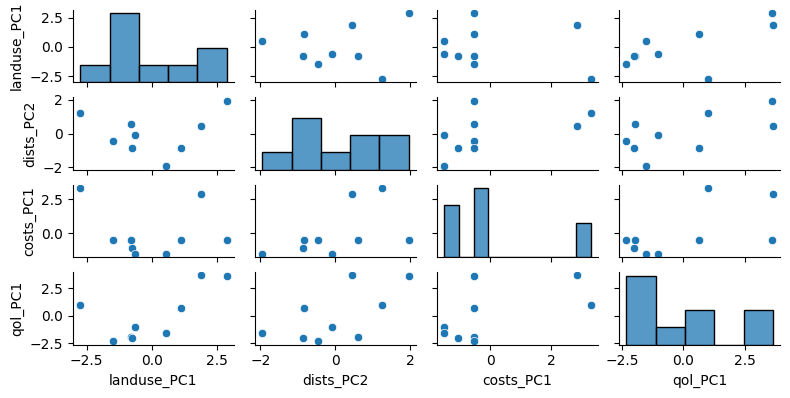

In [105]:
sns.pairplot(sig_pca_df , height=1, aspect =2)

In [101]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pca_df["landuse_PC1"],
    y=pca_df["qol_PC1"], 
    mode='markers',
    name="Land Use"
))

fig.add_trace(go.Scatter(
    x=pca_df["dists_PC2"],
    y=pca_df["qol_PC1"], 
    mode='markers',
    name="Distance"
))

fig.add_trace(go.Scatter(
    x=pca_df["costs_PC1"],
    y=pca_df["qol_PC1"], 
    mode='markers',
    name="Distance"
))

fig.update_layout(xaxis_title='Predictor Variable Principal Components',
                  yaxis_title='Quality of Life Principal Component',
            )

<AxesSubplot: >

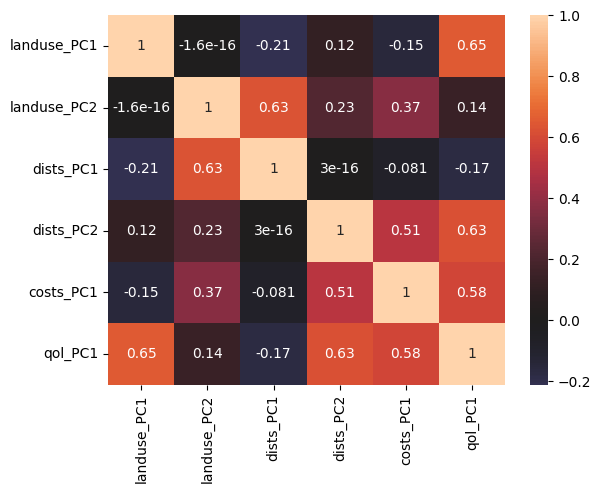

In [95]:
sns.heatmap(pca_df.corr(), annot=True, center=0)

## Significance

In [112]:
sig_pca_df.round(2)

,landuse_PC1,dists_PC2,costs_PC1,qol_PC1
0,-0.80,0.59,-0.52,-1.97
1,2.87,1.95,-0.52,3.60
2,-0.76,-0.86,-1.05,-2.02
3,-1.47,-0.47,-0.52,-2.32
4,1.12,-0.84,-0.52,0.65
5,-0.64,-0.10,-1.51,-1.02
6,1.88,0.43,2.84,3.64
7,0.53,-1.95,-1.51,-1.54
8,-2.75,1.23,3.31,0.99


In [108]:
sig_pca_df.columns

Index(['landuse_PC1', 'dists_PC2', 'costs_PC1', 'qol_PC1'], dtype='object')

### random forest 1

In [160]:
def rf_r2(y, X, columns=None):

    if columns.all()==None:
        columns = X.columns
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    forest = RandomForestRegressor(random_state=1)
    forest.fit(X_train, y_train)

    # alt way to calc
    result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    
    forest_importances = pd.Series(result.importances_mean, index=columns)


    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.close()

    forest.score
    y_test_pred = forest.predict(X_test)
    r2 = r2_score(y_test, y_test_pred)

    return r2, fig 

/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_80717/253311300.py:22: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



-1.6328229046501106


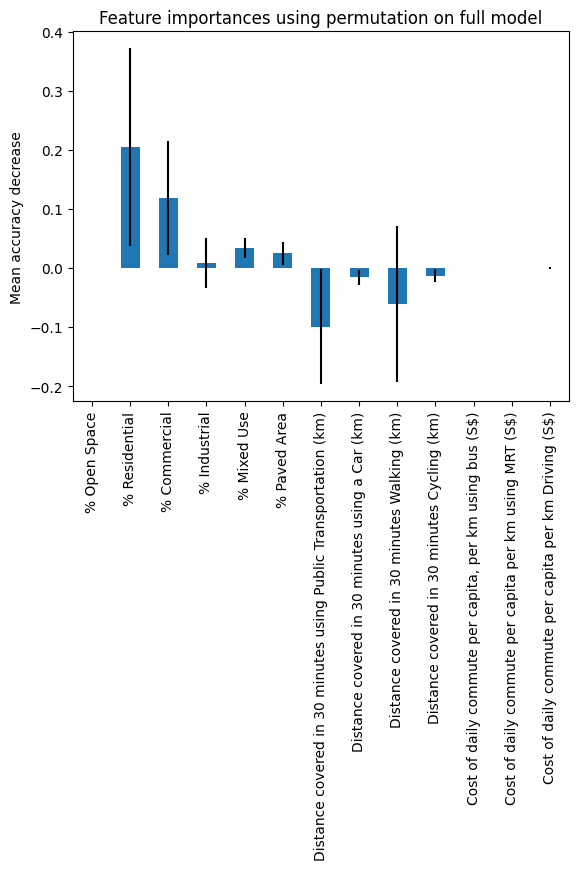

In [161]:
y_orig = qol
y = preprocessing.scale(y_orig)
X_orig = pd.concat([landuse, dists, costs], axis=1)
X = preprocessing.scale(X_orig)

r2, fig = rf_r2(y, X, X_orig.columns)
print(r2)
fig


In [ ]:
y = sig_pca_df["qol_PC1"]
X = sig_pca_df.iloc[:, 0:3]
r2, fig = rf_r2(y, X)
print(r2)
fig

0.5148683658482935


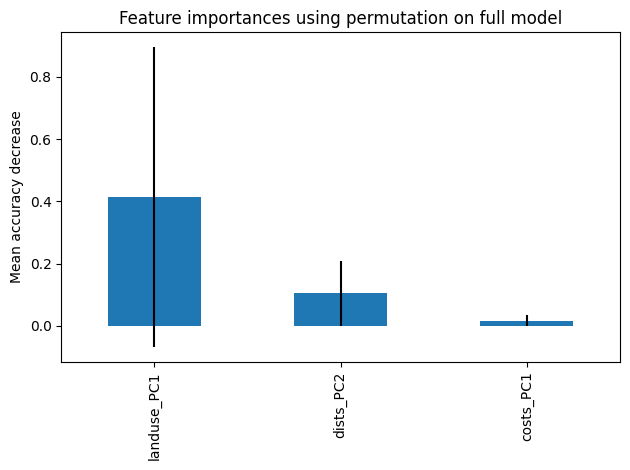

In [150]:
y = sig_pca_df["qol_PC1"]
X = sig_pca_df.iloc[:, 0:3]
r2, fig = rf_r2(y, X)
print(r2)
fig


0.09708402287041351


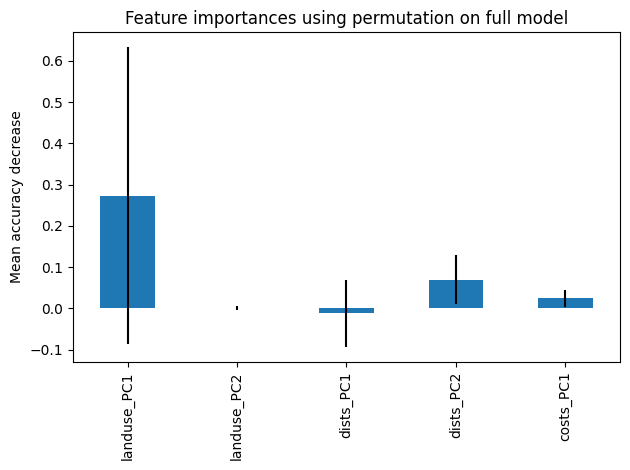

In [149]:
y = pca_df["qol_PC1"]
X = pca_df.iloc[:, 0:-1]
r2, fig = rf_r2(y, X)
print(r2)
fig

### anova 

In [116]:
y = sig_pca_df["qol_PC1"]
x = sig_pca_df["landuse_PC1"]
#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                qol_PC1   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     5.163
Date:                Mon, 20 Mar 2023   Prob (F-statistic):             0.0573
Time:                        14:36:32   Log-Likelihood:                -17.461
No. Observations:                   9   AIC:                             38.92
Df Residuals:                       7   BIC:                             39.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.488e-17      0.636   1.33e-16      

/Users/julietnwagwuume-ezeoke/_ClassCode/classenv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=9



In [119]:
sm.stats.anova_lm(model, typ=1)

AttributeError: 'PandasData' object has no attribute 'design_info'

In [114]:
model = ols("""qol_PC1 ~ C(landuse_PC1) """, data=sig_pca_df.round(2)).fit()

model.summary()

/Users/julietnwagwuume-ezeoke/_ClassCode/classenv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=9

/Users/julietnwagwuume-ezeoke/_ClassCode/classenv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning:

divide by zero encountered in divide

/Users/julietnwagwuume-ezeoke/_ClassCode/classenv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/julietnwagwuume-ezeoke/_ClassCode/classenv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning:

divide by zero encountered in scalar divide



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                qol_PC1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                nan
Time:                        14:33:51   Log-Likelihood:                 296.82
No. Observations:                   9   AIC:                            -575.6
Df Residuals:                       0   BIC:                            -573.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9900        inf          0        nan         nan         nan
C(landuse_PC1)[T.-1.47]    -3.3100        inf         -0        nan         nan         nan
C(landuse_PC1)[T.-0.8]     -2.9600        inf         -0        nan         nan         nan
C(landuse_PC1)[T.-0.76]    -3.0100        inf         -0        nan         nan         nan
C(landuse_PC1)[T.-0.64]    -2.0100        inf         -0        nan         nan         nan
C(landuse_PC1)[T.0.53]     -2.5300        inf         -0        nan         nan         nan
C(landuse_PC1)[T.1.12]     -0.3400        inf         -0        nan         nan         nan
C(landuse_PC1)[T.1.88]      2.6500        inf          0        nan         nan         nan
C(landuse_PC1)[T.2.87]      2.6100        inf          0        nan         nan         nan
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                0.377
Skew:                           0.500   Prob(JB):                        0.828
Kurtosis:                       2.915   Cond. No.                         9.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
# model = ols("""qol_PC1 ~ C(landuse_PC1) + C(dists_PC2) + C(costs_PC1) +
#                C(landuse_PC1):C(dists_PC2) + C(landuse_PC1):C(costs_PC1) + C(dists_PC2):C(costs_PC1) +
#                C(landuse_PC1):C(dists_PC2):C(costs_PC1)""", data=sig_pca_df).fit()

# model.summary()